In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
pd.set_option('max_columns', None)

url_matches_19_20 = 'https://api.opendota.com/api/explorer?sql=SELECT%0A%20%20%20%20%20%20%20%20%0Amatches.match_id%2C%0Amatches.start_time%2C%0A((player_matches.player_slot%20%3C%20128)%20%3D%20matches.radiant_win)%20win%2C%0Aplayer_matches.hero_id%2C%0Aplayer_matches.account_id%2C%0Aleagues.name%20leaguename%0AFROM%20matches%0AJOIN%20match_patch%20using(match_id)%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20player_matches%20using(match_id)%0AJOIN%20heroes%20on%20heroes.id%20%3D%20player_matches.hero_id%0ALEFT%20JOIN%20notable_players%20ON%20notable_players.account_id%20%3D%20player_matches.account_id%0ALEFT%20JOIN%20teams%20using(team_id)%0AWHERE%20TRUE%0AAND%20matches.start_time%20%3E%3D%20extract(epoch%20from%20timestamp%20%272019-12-31T23%3A00%3A00.000Z%27)%0AAND%20matches.start_time%20%3C%3D%20extract(epoch%20from%20timestamp%20%272020-12-31T23%3A00%3A00.000Z%27)%0AAND%20leagues.tier%20%3D%20%27professional%27%0AORDER%20BY%20matches.match_id%20NULLS%20LAST%0ALIMIT%20999999'
url_base_match = 'https://api.opendota.com/api/matches/'


def save_obj(obj, name):
    with open('./Data/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('./Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)






In [2]:
# Loading Data

data = load_obj('matchdata_19_20')

In [3]:
#Generating DF with Information used for prediction

df = pd.DataFrame(columns=['match_id','game_len','radiant_win','radiant1_hero_id','radiant1_kills','radiant1_deaths','radiant1_assists','radiant1_denies','radiant1_gold','radiant1_lh','radiant1_xp','radiant1_level','radiant1_creeps_stacked','radiant1_camps_stacked','radiant1_rune_pickups','radiant1_firstblood_claimed','radiant1_towers_killed','radiant1_roshans_killed','radiant1_obs_placed','radiant1_sen_placed','radiant2_hero_id','radiant2_kills','radiant2_deaths','radiant2_assists','radiant2_denies','radiant2_gold','radiant2_lh','radiant2_xp','radiant2_level','radiant2_creeps_stacked','radiant2_camps_stacked','radiant2_rune_pickups','radiant2_firstblood_claimed','radiant2_towers_killed','radiant2_roshans_killed','radiant2_obs_placed','radiant2_sen_placed','radiant3_hero_id','radiant3_kills','radiant3_deaths','radiant3_assists','radiant3_denies','radiant3_gold','radiant3_lh','radiant3_xp','radiant3_level','radiant3_creeps_stacked','radiant3_camps_stacked','radiant3_rune_pickups','radiant3_firstblood_claimed','radiant3_towers_killed','radiant3_roshans_killed','radiant3_obs_placed','radiant3_sen_placed','radiant4_hero_id','radiant4_kills','radiant4_deaths','radiant4_assists','radiant4_denies','radiant4_gold','radiant4_lh','radiant4_xp','radiant4_level','radiant4_creeps_stacked','radiant4_camps_stacked','radiant4_rune_pickups','radiant4_firstblood_claimed','radiant4_towers_killed','radiant4_roshans_killed','radiant4_obs_placed','radiant4_sen_placed','radiant5_hero_id','radiant5_kills','radiant5_deaths','radiant5_assists','radiant5_denies','radiant5_gold','radiant5_lh','radiant5_xp','radiant5_level','radiant5_creeps_stacked','radiant5_camps_stacked','radiant5_rune_pickups','radiant5_firstblood_claimed','radiant5_towers_killed','radiant5_roshans_killed','radiant5_obs_placed','radiant5_sen_placed','dire1_hero_id','dire1_kills','dire1_deaths','dire1_assists','dire1_denies','dire1_gold','dire1_lh','dire1_xp','dire1_level','dire1_creeps_stacked','dire1_camps_stacked','dire1_rune_pickups','dire1_firstblood_claimed','dire1_towers_killed','dire1_roshans_killed','dire1_obs_placed','dire1_sen_placed','dire2_hero_id','dire2_kills','dire2_deaths','dire2_assists','dire2_denies','dire2_gold','dire2_lh','dire2_xp','dire2_level','dire2_creeps_stacked','dire2_camps_stacked','dire2_rune_pickups','dire2_firstblood_claimed','dire2_towers_killed','dire2_roshans_killed','dire2_obs_placed','dire2_sen_placed','dire3_hero_id','dire3_kills','dire3_deaths','dire3_assists','dire3_denies','dire3_gold','dire3_lh','dire3_xp','dire3_level','dire3_creeps_stacked','dire3_camps_stacked','dire3_rune_pickups','dire3_firstblood_claimed','dire3_towers_killed','dire3_roshans_killed','dire3_obs_placed','dire3_sen_placed','dire4_hero_id','dire4_kills','dire4_deaths','dire4_assists','dire4_denies','dire4_gold','dire4_lh','dire4_xp','dire4_level','dire4_creeps_stacked','dire4_camps_stacked','dire4_rune_pickups','dire4_firstblood_claimed','dire4_towers_killed','dire4_roshans_killed','dire4_obs_placed','dire4_sen_placed','dire5_hero_id','dire5_kills','dire5_deaths','dire5_assists','dire5_denies','dire5_gold','dire5_lh','dire5_xp','dire5_level','dire5_creeps_stacked','dire5_camps_stacked','dire5_rune_pickups','dire5_firstblood_claimed','dire5_towers_killed','dire5_roshans_killed','dire5_obs_placed','dire5_sen_placed'])
for match in data:
    entry=[]
    entry.append(match["match_id"])
    entry.append(match["duration"])
    entry.append(match["radiant_win"])
    for player in match["players"]:
        entry.append(player['hero_id'])
        entry.append(player['kills'])
        entry.append(player['deaths'])
        entry.append(player['assists'])
        entry.append(player['denies'])
        entry.append(player['gold_per_min'])
        entry.append(player['last_hits'])
        entry.append(player['xp_per_min'])
        entry.append(player['level'])
        entry.append(player['creeps_stacked'])
        entry.append(player['camps_stacked'])
        entry.append(player['rune_pickups'])
        entry.append(player['firstblood_claimed'])
        entry.append(player['towers_killed'])
        entry.append(player['roshans_killed'])
        entry.append(player['obs_placed'])
        entry.append(player['sen_placed'])



    df.loc[len(df)] = entry

save_obj(df,"cleaned_df_matchdata")

In [2]:
# Working DF

df_loaded = load_obj("cleaned_df_matchdata")

In [3]:
#Data Cleaning

df_loaded.dropna(axis=0,how= 'any', inplace = True)
df_loaded= df_loaded.astype('int64')
df_cleaned = df_loaded.drop(columns=["radiant_win"])
df_targets = df_loaded[['match_id','radiant_win']]
df_cleaned.set_index("match_id", inplace = True)
df_targets.set_index("match_id", inplace = True)
# df_cleaned.reset_index(level=0, inplace=True)

print(f'Number of samples in cleaned df: {df_cleaned.shape[0]}')
print(f'Number of columns in cleaned df: {df_cleaned.shape[1]}')

for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any():
        print(col, df_cleaned[col].isnull().sum())

X = df_cleaned #.drop(columns=["radiant_win","next_roshan_team"])
y = df_targets
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)
print(f'Number of samples in train: {X_train.shape[0]}')
print(f'Number of columns in train: {X_train.shape[1]}')

print(f'Number of samples in test: {X_test.shape[0]}')
print(f'Number of columns in test: {X_test.shape[1]}')




Number of samples in cleaned df: 21351
Number of columns in cleaned df: 171
Number of samples in train: 17080
Number of columns in train: 171
Number of samples in test: 4271
Number of columns in test: 171


# Descriptive Analysis

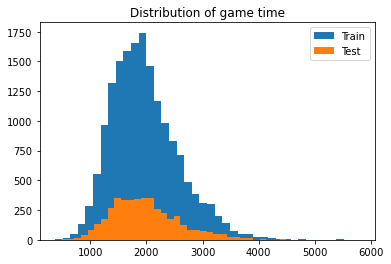

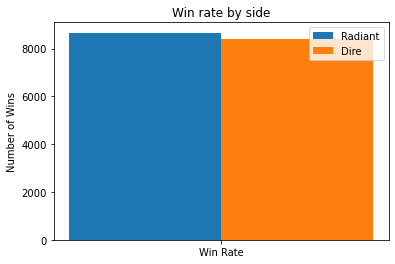

In [6]:
#See if Distribution of the game lenght is similar in test and train set.
plt.hist(X_train['game_len'], bins=40, label='Train');
plt.hist(X_test['game_len'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

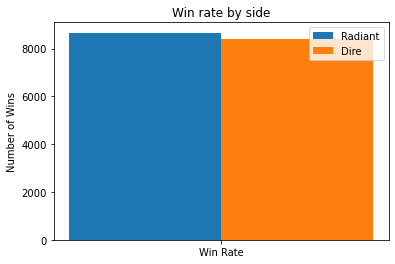

In [7]:
radiant_win,dire_win=y_train["radiant_win"].value_counts()

labels = ['Win Rate']
men_means = [radiant_win]
women_means = [dire_win]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Radiant')
rects2 = ax.bar(x + width/2, women_means, width, label='Dire')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Wins')
ax.set_title('Win rate by side')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()




**Test logistic regression**

In [8]:
logit = LogisticRegression(C=1, solver='lbfgs', max_iter=500,
                           random_state=17, n_jobs=4,
                          multi_class='multinomial')
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', logit)])

In [9]:
%%time
logit_pipe.fit(X_train, y_train)
# this may take a while...

Wall time: 10.7 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('logit',
                 LogisticRegression(C=1, max_iter=500,
                                    multi_class='multinomial', n_jobs=4,
                                    random_state=17))])

In [12]:
logit_val_pred = logit_pipe.predict(X_test)
accuracy_score(y_test, logit_val_pred)

0.9812690236478576

In [13]:
first_forest = RandomForestClassifier(
    n_estimators=100, random_state=17, n_jobs=4)

In [15]:
%%time
first_forest.fit(X_train, y_train)
# this may take a while...

Wall time: 4.19 s


RandomForestClassifier(n_jobs=4, random_state=17)

In [16]:
forest_val_pred = first_forest.predict(X_test)
accuracy_score(y_test, forest_val_pred)

0.96183563568251

In [17]:
pd.DataFrame(first_forest.feature_importances_,
             index=X_train.columns, columns=['Importance']).sort_values(
    by='Importance', ascending=False)[:10]

,Importance
dire3_assists,0.050887
radiant3_assists,0.049442
dire2_assists,0.045877
dire4_assists,0.044402
radiant4_assists,0.038607
radiant5_assists,0.032667
radiant2_assists,0.031800
dire1_assists,0.031396
dire5_assists,0.028397
radiant1_assists,0.026757


In [18]:
lgb_clf = LGBMClassifier(random_state=17)

In [19]:
%%time
lgb_clf.fit(X_train, y_train)

Wall time: 2.03 s


LGBMClassifier(random_state=17)

In [20]:
accuracy_score(y_test, lgb_clf.predict(X_test))

0.9730742214937954

**1 stage of hyper-param tuning: tuning model complexity**

In [21]:
param_grid = {'num_leaves': [7, 15, 31, 63],
              'max_depth': [3, 4, 5, 6, -1]}

In [22]:
grid_searcher = GridSearchCV(estimator=lgb_clf, param_grid=param_grid,
                             cv=5, verbose=1, n_jobs=4)

In [23]:
grid_searcher.fit(X_train, y_train) # This may take a while!

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=17), n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, -1],
                         'num_leaves': [7, 15, 31, 63]},
             verbose=1)

In [24]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 6, 'num_leaves': 15}, 0.9741217798594848)

In [25]:
accuracy_score(y_test, grid_searcher.predict(X_test))

0.9690938890189651

**2 stage of hyper-param tuning: convergence:**

In [26]:
# This may take a while
num_iterations = 200
lgb_clf2 = LGBMClassifier(random_state=17, max_depth=6,
                          num_leaves=15, n_estimators=num_iterations,
                          n_jobs=1)

param_grid2 = {'learning_rate': np.logspace(-3, 0, 10)}
grid_searcher2 = GridSearchCV(estimator=lgb_clf2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)
grid_searcher2.fit(X_train, y_train)
print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(accuracy_score(y_test, grid_searcher2.predict(X_test)))
# This may take very long !!!

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'learning_rate': 0.21544346900318823} 0.9787470725995316
0.9733083586981971


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.2min finished


In [27]:
final_lgb = LGBMClassifier(n_estimators=200, num_leaves=15,
                           learning_rate=0.22, max_depth=6,
                         n_jobs=4)


In [28]:
%%time
final_lgb.fit(X_train, y_train)
# This may take some time

Wall time: 2.85 s


LGBMClassifier(learning_rate=0.22, max_depth=6, n_estimators=200, n_jobs=4,
               num_leaves=15)

In [29]:
%%time
lgb_final_pred = final_lgb.predict(X_test)

Wall time: 69.5 ms


In [30]:
print(accuracy_score(y_test, lgb_final_pred))

0.975649730742215


## Interpretation

With the Features gold_per_minute, kills, deaths, assists,last hits, xp_per_minute, etc.  per Player, it gets really easy to predict how the outcome of the game was. As we can see with the accuracy scores between 96 - 98%.
And it is not really interesting predicting who won the game after the game has already finished. So we tried predicting the winner team before the game has started in the Jupyter Notebook Prediction_minute_0.